In [1]:
import pandas as pd
import stashapi.log as log
from stashapi.stashapp import StashInterface
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Get the API key
api_key = os.getenv("ApiKey")

stash = StashInterface(
    {
        "scheme": "http",
        "host": "fraktal.auvilankuja.fi",
        "port": "9999",
        "logger": log,
        "ApiKey": api_key
    }
)

d Using stash (v0.25.1-0) endpoint at http://fraktal.auvilankuja.fi:9999/graphql


In [2]:
def get_parent_studio_id(studio):
    if studio["parent_studio"] is not None:
        return studio["parent_studio"]["id"]
    return None

studios = stash.find_studios({})
df_studios = pd.DataFrame(studios)
df_studios["parent_studio_id"] = df_studios.apply(get_parent_studio_id, axis=1)

In [3]:
performers = stash.find_performers({})
df_performers = pd.DataFrame(performers)


In [4]:
# Lookup functions
def get_studio(studio_id):
    return df_studios[df_studios["id"] == studio_id]

def get_performer(performer_id):
    return df_performers[df_performers["id"] == performer_id]

In [5]:
current_studio = get_studio("10")
current_studio_id = current_studio["id"].values[0]

current_studio

,id,name,url,parent_studio,child_studios,aliases,ignore_auto_tag,image_path,scene_count,image_count,gallery_count,performer_count,movie_count,stash_ids,rating100,details,created_at,updated_at,movies,parent_studio_id
594,10,Passion HD,https://passion-hd.com/,{'id': '238'},[],[],False,http://fraktal.auvilankuja.fi:9999/studio/10/i...,11,0,0,13,0,"[{'endpoint': 'https://stashdb.org/graphql', '...",NaN,,2023-01-25T14:33:12Z,2024-04-21T11:17:28Z,[],238


In [14]:
# Find scenes with specific title
# scenes_data = stash.find_scenes({ "title": { "value": "sucker", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
# scenes_data = stash.find_scenes({ "performers": { "value": ["210"], "excludes": [], "modifier": "INCLUDES_ALL" } }, filter={ "per_page": 120, "page": 6, "sort": "path", "direction": "DESC" })
scenes_data = stash.find_scenes({
    # "studios": { "value": [current_studio_id], "excludes": [], "modifier": "INCLUDES" },
    "stash_id_endpoint": { "endpoint": "", "stash_id": "", "modifier": "NOT_NULL" },
}, filter={ "per_page": 500, "page": 3, "sort": "path", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)
print(len(scenes_df))

500


In [15]:
def get_path(files):
    return files[0]["path"] if files else None

def get_basename(files):
    return files[0]["basename"] if files else None

def get_first_file_resolution(files):
    return str(files[0]["width"]) + "x" + str(files[0]["height"]) if files else None

def get_studio_value(studio):
    if (studio is None):
        return "Unknown Studio"

    stash_studio = get_studio(studio["id"])
    if stash_studio.empty:
        return "Unknown Studio"
    
    parent_stash_studio = get_studio(stash_studio["parent_studio_id"].iloc[0])
    if not parent_stash_studio.empty:
        return parent_stash_studio["name"].iloc[0] + "꞉ " + stash_studio["name"].iloc[0]

    return stash_studio["name"].iloc[0]


def get_performers(performers):
    if len(performers) == 0:
        return "Unknown performers"

    stash_performers = []
    for performer in performers:
        stash_performer = get_performer(performer["id"])
        if not stash_performer.empty:
            stash_performers.append(stash_performer)
    
    # Concatenate the data frames into a single data frame
    df_stash_performers = pd.concat(stash_performers)

    # Sort by gender with a custom order and then by name
    # Define a custom sort order for gender
    gender_priority = {
        'TRANSGENDER': 1,
        'FEMALE': 2,
        'MALE': 3
    }
    
    # Map the 'gender' column to these priorities
    df_stash_performers['gender_priority'] = df_stash_performers['gender'].map(gender_priority).fillna(4)  # Any undefined genders get a default value

    # Now sort by this priority, and then by name
    
    df_stash_performers.sort_values(by=['gender_priority', 'name'], inplace=True)
    
    # Cleanup: remove the auxiliary 'gender_priority' column if no longer needed
    df_stash_performers.drop('gender_priority', axis=1, inplace=True)

    # Return a comma-separated string of names
    return ', '.join(df_stash_performers['name'])

# Define a function to get the first file if available
def get_suffix(files):
    first_file = files[0]["basename"] if files else None
    file_suffix = os.path.splitext(first_file)[1] if first_file else None
    return file_suffix

def title_case_except_acronyms(text):
    words = text.split()
    title_cased_words = []
    for word in words:
        # Check if the word contains an apostrophe
        if "'" in word:
            # Split the word at the apostrophe and process each part
            parts = word.split("'")
            new_parts = [parts[0].title()]  # Always capitalize the part before the apostrophe
            if len(parts) > 1:
                # Never capitalize after the apostrophe
                new_parts.append(parts[1])
            # Rejoin the parts with an apostrophe
            title_cased_words.append("'".join(new_parts))
        else:
            # Apply the original logic if there's no apostrophe
            title_cased_words.append(word if word.isupper() and len(word) > 1 else word.title())

    return ' '.join(title_cased_words)

def clean_title(title):
    title = title_case_except_acronyms(title)
    return title.replace(":", "꞉").replace("?", "？").replace("/", "∕").replace("\\", "＼").replace("*", "＊").replace("\"", "＂").replace("<", "＜").replace(">", "＞").replace("|", "｜").replace("  ", " ")

import os
import re

def convert_stash_path_to_windows_path(files):
    # Check if files is not empty and contains a dictionary with a "path" key
    if not files or "path" not in files[0]:
        return None
    
    path = files[0]["path"]
    if path:
        # Try to extract the drive letter from the path using a regex
        match = re.search(r'/videos_(\w)/', path)
        if match:
            drive_letter = match.group(1).upper()
            # Replace '/videos_x/' with 'X:\' using the drive letter extracted
            path = re.sub(r'/videos_\w/', drive_letter + ':\\\\Culture\\\\Videos\\\\', path)
            # Normalize the path to use backslashes instead of forward slashes
            path = os.path.normpath(path)
        else:
            return None  # Return None if no matching pattern is found
    return path

# Apply the function to the 'files' column
scenes_df['path'] = scenes_df['files'].apply(get_basename)
scenes_df['windows_path'] = scenes_df['files'].apply(convert_stash_path_to_windows_path)
scenes_df['windows_directory'] = scenes_df['files'].apply(lambda files: os.path.dirname(convert_stash_path_to_windows_path(files)))
scenes_df['basename'] = scenes_df['files'].apply(get_basename)
scenes_df['resolution'] = scenes_df['files'].apply(get_first_file_resolution)
scenes_df['primary_studio'] = scenes_df['studio'].apply(get_studio_value)
scenes_df['performers_str'] = scenes_df['performers'].apply(get_performers)
scenes_df['suffix'] = scenes_df['files'].apply(get_suffix)


In [10]:
import pandas as pd
import requests


url = f"http://localhost:33333/api/files?status=both"
response = requests.get(url)
laputin_files = response.json()
df_laputin_files = pd.DataFrame(laputin_files)
df_laputin_files['xxhash'] = df_laputin_files['metadata'].apply(
    lambda x: x.get('hashes', {}).get('xxhash') if x else None
)

In [16]:
df_laputin_files = df_laputin_files.drop_duplicates(subset="path")
scenes_df["xxhash"] = scenes_df["windows_path"].map(df_laputin_files.set_index("path")["xxhash"])


In [17]:
scenes_df['fs_title'] = scenes_df['title'].apply(clean_title)
scenes_df['new_filename'] = scenes_df['primary_studio'] + ' – ' + scenes_df['date'] + ' – ' + scenes_df['code'] + ' – ' + scenes_df['fs_title'] + ' – ' + scenes_df['performers_str'] + ' [' + scenes_df['xxhash'] + ']' + scenes_df['suffix']
scenes_df['new_path'] = scenes_df['windows_directory'] + '\\' + scenes_df['new_filename']

renames_df = scenes_df[['windows_path', 'new_path', 'xxhash']][scenes_df['windows_path'] != scenes_df['new_path']].sort_values(by='windows_path')


In [13]:
import os
import shutil

for index, row in renames_df.iterrows():
    old_path = row['windows_path']
    new_path = row['new_path']

    if (row['xxhash'] is None):
        print(f"XXHash not found for {old_path}")
        continue

    if not pd.isna(new_path) and os.path.isfile(old_path):
        if not os.path.exists(new_path):
            try:
                shutil.move(old_path, new_path)
                print(f"Moved file from {old_path} to {new_path}")
            except Exception as e:
                print(f"Failed to move file from {old_path} to {new_path}: {e}")
        else:
            print(f"A file already exists in the new path: {new_path}")


Moved file from Z:\Culture\Videos\Sites\Fake Hostel\Fake Hub - Fake Hostel - 2019-06-07 - 4358375 - Summer's Coming - Ginebra Bellucci, Stacy Cruz & Juan Lucho [1080p].mp4 to Z:\Culture\Videos\Sites\Fake Hostel\Fakehub꞉ Fake Hostel – 2019-06-07 –  – Summer's Coming – Ginebra Bellucci, Stacy Cruz, Juan Lucho [20b2c916c1c2f86b].mp4
Moved file from Z:\Culture\Videos\Sites\Fake Hostel\Fake Hub - Fake Hostel - 2019-07-19 - 4361139 - A Deep Inspection - Alexis Crystal, Kittina Clariette & Lutro Steel [1080p].mp4 to Z:\Culture\Videos\Sites\Fake Hostel\Fakehub꞉ Fake Hostel – 2019-07-19 –  – A Deep Inspection – Alexis Crystal, Kittina Ivory, Lutro Steel [21b7ce7870c608fc].mp4
Moved file from Z:\Culture\Videos\Sites\Fake Hostel\Fake Hub - Fake Hostel - 2019-07-26 - 4361473 - Two Tight Bumholes - Kittina Clariette, Elena Vega & Steve Q [1080p].mp4 to Z:\Culture\Videos\Sites\Fake Hostel\Fakehub꞉ Fake Hostel – 2019-07-26 – 4361473 – Two Tight Bumholes – Amanda Hill, Kittina Ivory, Steve Q [57ee7722

Non-renaming things start from here.

In [46]:
# Find female performers
female_performers = stash.find_performers({ "gender": { "value": "FEMALE", "modifier": "EQUALS" } })
df_female_performers = pd.DataFrame(female_performers)
df_female_performers['birthdate'] = pd.to_datetime(df_female_performers['birthdate'])

In [47]:
favorite_performers = stash.find_performers({ "filter_favorites": True })
df_favorite_performers = pd.DataFrame(favorite_performers)
df_favorite_performers['birthdate'] = pd.to_datetime(df_favorite_performers['birthdate'])

In [48]:
from IPython.display import Image
from IPython.display import display

# Assuming df is your DataFrame and 'image_path' is your column with URLs
x = Image(url= df_favorite_performers['image_path'][0]) 
display(x)

In [33]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.2 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.2 kB ? eta -:--:--
     -------------- ------------------------ 61.4/162.2 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 162.2/162.2 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.9/7.6 MB 29.7 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/7.6 MB 37.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 40.1 MB/s eta 0:00:01
   --------------------------- ------------ 5.2/7.6 MB 36.7 MB/s eta 0:00:01
   ---------------------------------- ----- 6.7/7.6 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 34.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/187.7 kB ? eta -:--:--
   -----------

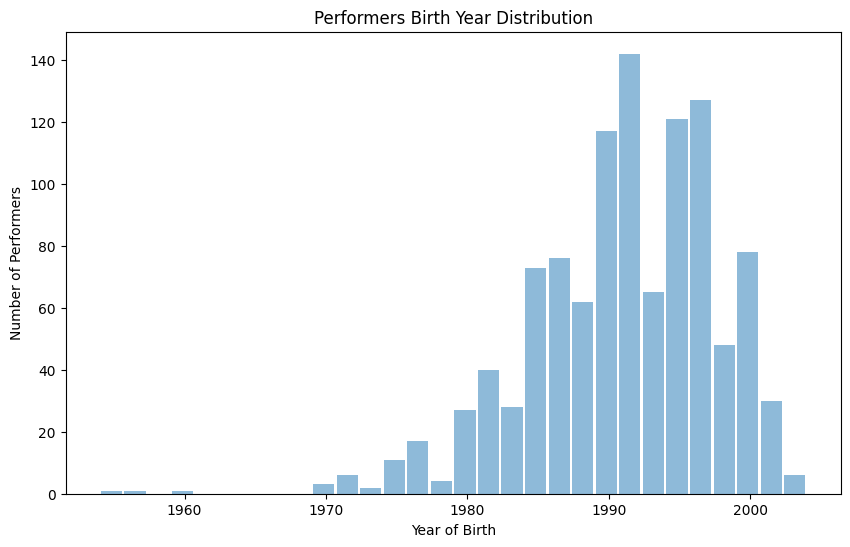

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_female_performers['birthdate'].dt.year.hist(bins=30, alpha=0.5, rwidth=0.9)
plt.xlabel('Year of Birth')
plt.ylabel('Number of Performers')
plt.title('Performers Birth Year Distribution')
plt.grid(False)
plt.show()

In [ ]:
# Find scenes with specific performer
scenes_data = stash.find_scenes({ "title": { "value": "erections", "modifier": "INCLUDES" } }, filter={ "per_page": 40, "page": 1, "sort": "date", "direction": "DESC" })
scenes_df = pd.DataFrame(scenes_data)